<img src="https://minas.medellin.unal.edu.co/eventos/latwaves2018/images/logo_unal.png" alt="unal logo" width="500"/>

#**Trabajo Final de Maestría**
##Ingeniería de Sistemas y Computación - Perfil profundización.
Joan Gabriel Bofill Barrera

---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import re
import nltk
import seaborn as sns
import os
import string
from nltk.corpus import stopwords

In [ ]:
# Importar los datos de drive
from google.colab import drive
from google.colab import files
import io
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Tesis/train_modificado.csv')
test = pd.read_csv('/content/drive/MyDrive/Tesis/test_modificado.csv')

Mounted at /content/drive


In [ ]:
TARGET_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

def load_dataset(df):
    text = df['full_text']
    targets = df[TARGET_COLS]
    return tf.data.Dataset.from_tensor_slices((text, targets))

raw_ds = load_dataset(train)

for text, targets in raw_ds.take(3):
    print(text)
    print(targets, '\n')

In [ ]:
MAX_TOKENS = 50000
bag_vectorization = tf.keras.layers.TextVectorization(
    ngrams=4,
    max_tokens=MAX_TOKENS,
    output_mode="multi_hot",
)
text_only_ds = raw_ds.map(lambda x, y: x)
bag_vectorization.adapt(text_only_ds)
print(f'\nThe first 100 tokens in this vocabulary: {bag_vectorization.get_vocabulary()[:100]}\n')
print(f'\nThe last 100 tokens in this vocabulary: {bag_vectorization.get_vocabulary()[-100:]}\n')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(train, test_size=0.1, random_state=42)

In [ ]:
BUFFER_SIZE = len(train_df)
BATCH_SIZE = 8
AUTO = tf.data.experimental.AUTOTUNE

def get_train_ds():
    ds = load_dataset(train_df)
    ds = ds.map(lambda x, y: (bag_vectorization(x), tf.cast(y, tf.float32)), num_parallel_calls=AUTO)
    ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
    return ds

def get_val_ds():
    ds = load_dataset(val_df)
    ds = ds.map(lambda x, y: (bag_vectorization(x), tf.cast(y, tf.float32)), num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

In [ ]:
train_ds = get_train_ds()
val_ds = get_val_ds()

for inputs, targets in train_ds.take(1):
    print(f'Training inputs shape: {inputs.shape}')
    print(f'Training inputs dtype: {inputs.dtype}')
    print(f'Training targets shape: {targets.shape}')
    print(f'Training targets dtype: {targets.dtype}')

for inputs, targets in val_ds.take(1):
    print(f'Validation inputs shape: {inputs.shape}')
    print(f'Validation inputs dtype: {inputs.dtype}')
    print(f'Validation targets shape: {targets.shape}')
    print(f'Validation targets dtype: {targets.dtype}')

Training inputs shape: (8, 50000)
Training inputs dtype: <dtype: 'float32'>
Training targets shape: (8, 6)
Training targets dtype: <dtype: 'float32'>
Validation inputs shape: (8, 50000)
Validation inputs dtype: <dtype: 'float32'>
Validation targets shape: (8, 6)
Validation targets dtype: <dtype: 'float32'>


In [ ]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 50000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

#Model

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.mean(K.sqrt(K.mean(K.square(y_pred - y_true), axis=0)))

In [ ]:
def get_model(max_tokens=MAX_TOKENS, hidden_dim=16):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = tf.keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(6)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                 loss=root_mean_squared_error,
                 metrics=['mse'],
                 )
    return model

In [ ]:
from keras import backend as K

In [ ]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50000)]           0         
                                                                 
 dense (Dense)               (None, 16)                800016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 800118 (3.05 MB)
Trainable params: 800118 (3.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./bag-of-words",
                                       monitor='val_loss',
                                       save_best_only=True,
                                       mode = 'min', verbose = 1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                                         patience = 2, min_lr = 1e-8,
                                         mode = 'min', verbose = 1)
]
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=callbacks)

<Axes: >

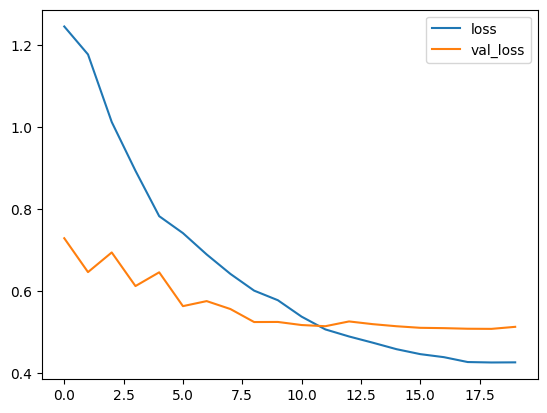

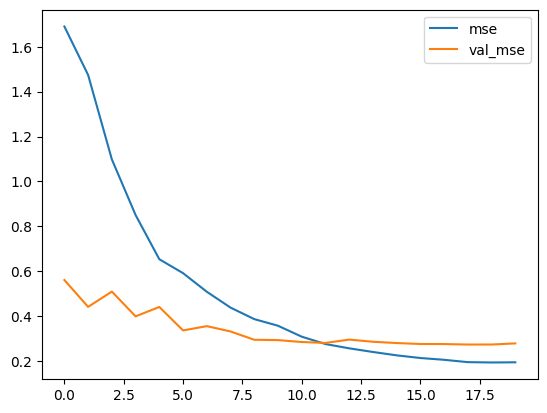

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['mse', 'val_mse']].plot()

In [ ]:
preds_list = []
for index, row in test.iterrows():
    preds = model.predict(
        tf.expand_dims(
            bag_vectorization(tf.convert_to_tensor(row['full_text'])),
            axis=0
        )
    )
    preds = np.clip(preds, 1, 5)
    preds_list.append(preds[0])

In [ ]:
preds_df = pd.DataFrame(preds_list, columns=['cohesion_pred', 'syntax_pred', 'vocabulary_pred', 'phraseology_pred', 'grammar_pred', 'conventions_pred'])
preds_df.head()

,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,2.527476,2.433598,2.706600,2.491318,2.367133,2.469814
1,3.103832,3.020108,3.216769,3.095765,3.032075,3.004087
2,3.485057,3.356894,3.546967,3.454348,3.377351,3.335189
3,2.995517,2.903366,3.132130,2.988454,2.888352,2.906355
4,3.530716,3.470226,3.583267,3.540255,3.559371,3.481040


In [ ]:
preds_df

,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,2.527476,2.433598,2.706600,2.491318,2.367133,2.469814
1,3.103832,3.020108,3.216769,3.095765,3.032075,3.004087
2,3.485057,3.356894,3.546967,3.454348,3.377351,3.335189
3,2.995517,2.903366,3.132130,2.988454,2.888352,2.906355
4,3.530716,3.470226,3.583267,3.540255,3.559371,3.481040
...,...,...,...,...,...,...
778,3.125584,3.044740,3.231530,3.115103,3.068272,3.044077
779,2.961704,2.882339,3.099468,2.953777,2.877984,2.883921
780,2.897371,2.858889,3.049291,2.927950,2.874524,2.863045
781,3.914969,3.776783,3.926389,3.895339,3.841853,3.721070


In [ ]:
test

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,...,max_sent_len,min_sent_len,med_sent_len,std_sent_len,num_sent,compound,negative,positive,neutral,char_len
0,1552,772D27D400BB,it god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0,198,...,54,0,39.0,17.293387,7,0.9693,0.087,0.162,0.751,424
1,2114,9E8F3C6405CA,why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0,113,...,51,0,43.0,19.450793,6,0.9735,0.045,0.127,0.828,278
2,1965,948771F795EB,we accomplish more when we are active and are ...,4.0,4.0,3.0,4.0,4.0,4.0,220,...,26,0,17.0,5.815045,23,0.9983,0.041,0.223,0.735,440
3,3856,FE14D7378CFB,do you agree or disagree about imagination bei...,3.0,3.0,3.5,3.0,3.5,3.5,188,...,33,10,24.5,6.474308,12,0.3327,0.077,0.089,0.834,347
4,1610,7AAE019F70D6,i disagree with the principal saying that all ...,3.5,3.5,3.5,3.5,3.0,3.5,246,...,62,17,46.0,16.215348,8,-0.9820,0.117,0.061,0.821,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,1740,83B3CD03C693,an enjoyable educational activity could be pla...,2.0,2.5,3.0,3.0,3.5,2.0,141,...,41,0,21.0,11.545129,10,0.9947,0.000,0.225,0.775,240
779,3760,F9D0974B3AF7,i disagree about extending school becauseparen...,2.5,2.5,3.0,3.0,2.5,2.5,127,...,33,0,13.0,9.839203,11,0.9647,0.008,0.133,0.859,218
780,1885,8E2EB0B4B92C,the author ralph waldo emerson once wrote to b...,2.0,3.0,3.0,3.0,3.0,2.5,291,...,37,0,17.0,7.035672,27,0.9988,0.054,0.228,0.718,484
781,2390,B1BF25C4C28B,my mom always tell me keep going until you rea...,4.0,3.5,4.0,3.5,3.5,4.0,292,...,31,0,21.0,6.945963,25,0.9856,0.084,0.140,0.777,531


In [ ]:
test.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

In [ ]:
preresults =pd.concat([test, preds_df], axis=1);preresults

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,...,negative,positive,neutral,char_len,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,1552,772D27D400BB,it god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0,198,...,0.087,0.162,0.751,424,2.527476,2.433598,2.706600,2.491318,2.367133,2.469814
1,2114,9E8F3C6405CA,why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0,113,...,0.045,0.127,0.828,278,3.103832,3.020108,3.216769,3.095765,3.032075,3.004087
2,1965,948771F795EB,we accomplish more when we are active and are ...,4.0,4.0,3.0,4.0,4.0,4.0,220,...,0.041,0.223,0.735,440,3.485057,3.356894,3.546967,3.454348,3.377351,3.335189
3,3856,FE14D7378CFB,do you agree or disagree about imagination bei...,3.0,3.0,3.5,3.0,3.5,3.5,188,...,0.077,0.089,0.834,347,2.995517,2.903366,3.132130,2.988454,2.888352,2.906355
4,1610,7AAE019F70D6,i disagree with the principal saying that all ...,3.5,3.5,3.5,3.5,3.0,3.5,246,...,0.117,0.061,0.821,444,3.530716,3.470226,3.583267,3.540255,3.559371,3.481040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,1740,83B3CD03C693,an enjoyable educational activity could be pla...,2.0,2.5,3.0,3.0,3.5,2.0,141,...,0.000,0.225,0.775,240,3.125584,3.044740,3.231530,3.115103,3.068272,3.044077
779,3760,F9D0974B3AF7,i disagree about extending school becauseparen...,2.5,2.5,3.0,3.0,2.5,2.5,127,...,0.008,0.133,0.859,218,2.961704,2.882339,3.099468,2.953777,2.877984,2.883921
780,1885,8E2EB0B4B92C,the author ralph waldo emerson once wrote to b...,2.0,3.0,3.0,3.0,3.0,2.5,291,...,0.054,0.228,0.718,484,2.897371,2.858889,3.049291,2.927950,2.874524,2.863045
781,2390,B1BF25C4C28B,my mom always tell me keep going until you rea...,4.0,3.5,4.0,3.5,3.5,4.0,292,...,0.084,0.140,0.777,531,3.914969,3.776783,3.926389,3.895339,3.841853,3.721070


In [ ]:
preresults["se_cohesion"]=(preresults["cohesion"]-preresults["cohesion_pred"])**2
preresults["se_syntax"]=(preresults["syntax"]-preresults["syntax_pred"])**2
preresults["se_vocabulary"]=(preresults["vocabulary"]-preresults["vocabulary_pred"])**2
preresults["se_phraseology"]=(preresults["phraseology"]-preresults["phraseology_pred"])**2
preresults["se_grammar"]=(preresults["grammar"]-preresults["grammar_pred"])**2
preresults["se_conventions"]=(preresults["conventions"]-preresults["conventions_pred"])**2

In [ ]:
results = pd.DataFrame()
results["se_cohesion"]=(preresults["cohesion"]-preresults["cohesion_pred"])**2
results["se_syntax"]=(preresults["syntax"]-preresults["syntax_pred"])**2
results["se_vocabulary"]=(preresults["vocabulary"]-preresults["vocabulary_pred"])**2
results["se_phraseology"]=(preresults["phraseology"]-preresults["phraseology_pred"])**2
results["se_grammar"]=(preresults["grammar"]-preresults["grammar_pred"])**2
results["se_conventions"]=(preresults["conventions"]-preresults["conventions_pred"])**2

In [ ]:
results

,se_cohesion,se_syntax,se_vocabulary,se_phraseology,se_grammar,se_conventions
0,0.223279,0.004409,0.042683,0.241393,0.134787,0.220725
1,0.010781,1.040621,0.046989,0.163406,0.001029,0.000017
2,0.265166,0.413585,0.299172,0.297736,0.387692,0.441973
3,0.000020,0.009338,0.135328,0.000133,0.374113,0.352414
4,0.000943,0.000886,0.006933,0.001620,0.312895,0.000359
...,...,...,...,...,...,...
778,1.266940,0.296742,0.053606,0.013249,0.186389,1.090096
779,0.213170,0.146183,0.009894,0.002137,0.142872,0.147395
780,0.805274,0.019912,0.002430,0.005191,0.015744,0.131801
781,0.007230,0.076609,0.005419,0.156293,0.116864,0.077802


In [ ]:
mse = results.mean();mse

se_cohesion       0.302882
se_syntax         0.284585
se_vocabulary     0.233026
se_phraseology    0.285923
se_grammar        0.343054
se_conventions    0.328379
dtype: float64

In [ ]:
rmse = np.sqrt(mse);rmse

se_cohesion       0.550347
se_syntax         0.533465
se_vocabulary     0.482728
se_phraseology    0.534718
se_grammar        0.585708
se_conventions    0.573044
dtype: float64

In [ ]:
np.mean(rmse)

0.5433348464930469

#Red Convolucional

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Input, Flatten, GlobalMaxPooling1D, Dropout

In [ ]:
def get_model():
    model = keras.Sequential([
        keras.Input(shape=(None, ), dtype="string"),
        vectorizor,
        keras.layers.Embedding(config.vocab_size, config.embed_size, input_length=config.maxlen),
        keras.layers.Conv1D(filters=128, kernel_size=8, activation="relu"),
        keras.layers.AveragePooling1D(pool_size=8),
        keras.layers.Conv1D(filters=256, kernel_size=4, activation="relu"),
        keras.layers.AveragePooling1D(pool_size=4),
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(32, kernel_initializer='he_uniform', activation='swish'),
        keras.layers.Dense(16, kernel_initializer='he_uniform', activation='swish'),
        keras.layers.Dense(len(config.target_columns))
    ])
    rmse = tf.keras.metrics.RootMeanSquaredError(name="rmse")
    model.compile(loss="mse", optimizer="adam", metrics=[rmse])
    return model

NameError: name 'x' is not defined

In [ ]:
vocab_size = 4096
embed_size = int(vocab_size ** 0.5)
batch_size = 64

In [ ]:
import keras

In [ ]:
def get_cnn_model(max_tokens=MAX_TOKENS, hidden_dim=[64,16]):
    # Capa de entrada
    inputs = Input(shape=(MAX_TOKENS,))
    x= keras.layers.Embedding(vocab_size, embed_size, input_length=MAX_TOKENS)(inputs),
    # Capa de embedding
    x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    # Global Max Pooling
    x = GlobalMaxPooling1D()(x)
    # Capa densa con dropout
    x = Dense(hidden_dim[0], activation="relu")(x)
    x = Dense(hidden_dim[1], activation="relu")(x)
    x = Dropout(0.3)(x)

    # Capa de salida
    outputs = Dense(6)(x)  # ajustar según la tarea de clasificación/regresión

    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=root_mean_squared_error,  # ajustar según sea necesario
                  metrics=['mse'])
    return model

In [ ]:
def get_cnn_model():
    model = keras.Sequential([
        keras.Input(shape=(MAX_TOKENS,)),
        keras.layers.Embedding(vocab_size, embed_size, input_length=MAX_TOKENS),
        keras.layers.Conv1D(filters=128, kernel_size=8, activation="relu"),
        keras.layers.AveragePooling1D(pool_size=8),
        keras.layers.Conv1D(filters=256, kernel_size=4, activation="relu"),
        keras.layers.AveragePooling1D(pool_size=4),
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(128, kernel_initializer='he_uniform', activation='swish'),
        keras.layers.Dense(16, kernel_initializer='he_uniform', activation='swish'),
        keras.layers.Dense(6)
    ])
    rmse = tf.keras.metrics.RootMeanSquaredError(name="rmse")
    model.compile(optimizer="adam",
                  loss=root_mean_squared_error,  # ajustar según sea necesario
                  metrics=['mse'])
    return model

In [ ]:
tf.keras.backend.clear_session()
model = get_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50000, 64)         262144    
                                                                 
 conv1d (Conv1D)             (None, 49993, 128)        65664     
                                                                 
 average_pooling1d (Average  (None, 6249, 128)         0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 6246, 256)         131328    
                                                                 
 average_pooling1d_1 (Avera  (None, 1561, 256)         0         
 gePooling1D)                                                    
                                                                 
 spatial_dropout1d (Spatial  (None, 1561, 256)         0

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./bag-of-words",
                                       monitor='val_loss',
                                       save_best_only=True,
                                       mode = 'min', verbose = 1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                                         patience = 2, min_lr = 1e-8,
                                         mode = 'min', verbose = 1)
]
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=callbacks)

<Axes: >

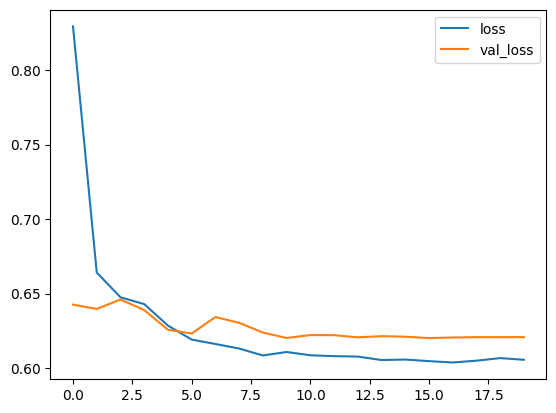

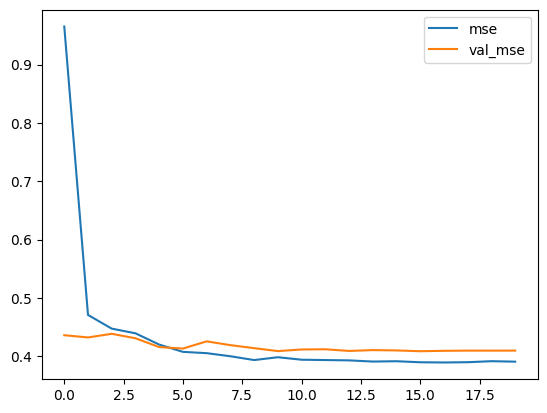

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['mse', 'val_mse']].plot()

In [ ]:
preds_list = []
for index, row in test.iterrows():
    preds = model.predict(
        tf.expand_dims(
            bag_vectorization(tf.convert_to_tensor(row['full_text'])),
            axis=0
        )
    )
    preds = np.clip(preds, 1, 5)
    preds_list.append(preds[0])

In [ ]:
preds_df = pd.DataFrame(preds_list, columns=['cohesion_pred', 'syntax_pred', 'vocabulary_pred', 'phraseology_pred', 'grammar_pred', 'conventions_pred'])
preds_df.head()

,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,3.171520,3.073342,3.271596,3.163944,3.080320,3.129295
1,2.980793,2.917302,3.095584,2.975588,2.953508,2.972615
2,3.273742,3.152014,3.367193,3.262718,3.132998,3.202575
3,3.111330,3.025054,3.216235,3.104980,3.042911,3.081671
4,3.193650,3.090822,3.291977,3.185500,3.093160,3.146160


In [ ]:
preds_df

,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,3.171520,3.073342,3.271596,3.163944,3.080320,3.129295
1,2.980793,2.917302,3.095584,2.975588,2.953508,2.972615
2,3.273742,3.152014,3.367193,3.262718,3.132998,3.202575
3,3.111330,3.025054,3.216235,3.104980,3.042911,3.081671
4,3.193650,3.090822,3.291977,3.185500,3.093160,3.146160
...,...,...,...,...,...,...
778,2.776033,2.741959,2.902396,2.768085,2.798977,2.792517
779,2.880027,2.831797,3.001148,2.873948,2.879316,2.885205
780,3.126264,3.037084,3.229871,3.119532,3.052451,3.093682
781,3.331792,3.191526,3.434569,3.321301,3.133256,3.222144


In [ ]:
test

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,...,max_sent_len,min_sent_len,med_sent_len,std_sent_len,num_sent,compound,negative,positive,neutral,char_len
0,1552,772D27D400BB,it god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0,198,...,54,0,39.0,17.293387,7,0.9693,0.087,0.162,0.751,424
1,2114,9E8F3C6405CA,why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0,113,...,51,0,43.0,19.450793,6,0.9735,0.045,0.127,0.828,278
2,1965,948771F795EB,we accomplish more when we are active and are ...,4.0,4.0,3.0,4.0,4.0,4.0,220,...,26,0,17.0,5.815045,23,0.9983,0.041,0.223,0.735,440
3,3856,FE14D7378CFB,do you agree or disagree about imagination bei...,3.0,3.0,3.5,3.0,3.5,3.5,188,...,33,10,24.5,6.474308,12,0.3327,0.077,0.089,0.834,347
4,1610,7AAE019F70D6,i disagree with the principal saying that all ...,3.5,3.5,3.5,3.5,3.0,3.5,246,...,62,17,46.0,16.215348,8,-0.9820,0.117,0.061,0.821,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,1740,83B3CD03C693,an enjoyable educational activity could be pla...,2.0,2.5,3.0,3.0,3.5,2.0,141,...,41,0,21.0,11.545129,10,0.9947,0.000,0.225,0.775,240
779,3760,F9D0974B3AF7,i disagree about extending school becauseparen...,2.5,2.5,3.0,3.0,2.5,2.5,127,...,33,0,13.0,9.839203,11,0.9647,0.008,0.133,0.859,218
780,1885,8E2EB0B4B92C,the author ralph waldo emerson once wrote to b...,2.0,3.0,3.0,3.0,3.0,2.5,291,...,37,0,17.0,7.035672,27,0.9988,0.054,0.228,0.718,484
781,2390,B1BF25C4C28B,my mom always tell me keep going until you rea...,4.0,3.5,4.0,3.5,3.5,4.0,292,...,31,0,21.0,6.945963,25,0.9856,0.084,0.140,0.777,531


In [ ]:
test.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

In [ ]:
preresults =pd.concat([test, preds_df], axis=1);preresults

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,...,negative,positive,neutral,char_len,cohesion_pred,syntax_pred,vocabulary_pred,phraseology_pred,grammar_pred,conventions_pred
0,1552,772D27D400BB,it god to have a possitive attitude when you d...,3.0,2.5,2.5,2.0,2.0,2.0,198,...,0.087,0.162,0.751,424,3.171520,3.073342,3.271596,3.163944,3.080320,3.129295
1,2114,9E8F3C6405CA,why do people ask more then one person for adv...,3.0,2.0,3.0,3.5,3.0,3.0,113,...,0.045,0.127,0.828,278,2.980793,2.917302,3.095584,2.975588,2.953508,2.972615
2,1965,948771F795EB,we accomplish more when we are active and are ...,4.0,4.0,3.0,4.0,4.0,4.0,220,...,0.041,0.223,0.735,440,3.273742,3.152014,3.367193,3.262718,3.132998,3.202575
3,3856,FE14D7378CFB,do you agree or disagree about imagination bei...,3.0,3.0,3.5,3.0,3.5,3.5,188,...,0.077,0.089,0.834,347,3.111330,3.025054,3.216235,3.104980,3.042911,3.081671
4,1610,7AAE019F70D6,i disagree with the principal saying that all ...,3.5,3.5,3.5,3.5,3.0,3.5,246,...,0.117,0.061,0.821,444,3.193650,3.090822,3.291977,3.185500,3.093160,3.146160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,1740,83B3CD03C693,an enjoyable educational activity could be pla...,2.0,2.5,3.0,3.0,3.5,2.0,141,...,0.000,0.225,0.775,240,2.776033,2.741959,2.902396,2.768085,2.798977,2.792517
779,3760,F9D0974B3AF7,i disagree about extending school becauseparen...,2.5,2.5,3.0,3.0,2.5,2.5,127,...,0.008,0.133,0.859,218,2.880027,2.831797,3.001148,2.873948,2.879316,2.885205
780,1885,8E2EB0B4B92C,the author ralph waldo emerson once wrote to b...,2.0,3.0,3.0,3.0,3.0,2.5,291,...,0.054,0.228,0.718,484,3.126264,3.037084,3.229871,3.119532,3.052451,3.093682
781,2390,B1BF25C4C28B,my mom always tell me keep going until you rea...,4.0,3.5,4.0,3.5,3.5,4.0,292,...,0.084,0.140,0.777,531,3.331792,3.191526,3.434569,3.321301,3.133256,3.222144


In [ ]:
preresults["se_cohesion"]=(preresults["cohesion"]-preresults["cohesion_pred"])**2
preresults["se_syntax"]=(preresults["syntax"]-preresults["syntax_pred"])**2
preresults["se_vocabulary"]=(preresults["vocabulary"]-preresults["vocabulary_pred"])**2
preresults["se_phraseology"]=(preresults["phraseology"]-preresults["phraseology_pred"])**2
preresults["se_grammar"]=(preresults["grammar"]-preresults["grammar_pred"])**2
preresults["se_conventions"]=(preresults["conventions"]-preresults["conventions_pred"])**2

In [ ]:
results = pd.DataFrame()
results["se_cohesion"]=(preresults["cohesion"]-preresults["cohesion_pred"])**2
results["se_syntax"]=(preresults["syntax"]-preresults["syntax_pred"])**2
results["se_vocabulary"]=(preresults["vocabulary"]-preresults["vocabulary_pred"])**2
results["se_phraseology"]=(preresults["phraseology"]-preresults["phraseology_pred"])**2
results["se_grammar"]=(preresults["grammar"]-preresults["grammar_pred"])**2
results["se_conventions"]=(preresults["conventions"]-preresults["conventions_pred"])**2

In [ ]:
results

,se_cohesion,se_syntax,se_vocabulary,se_phraseology,se_grammar,se_conventions
0,0.029419,0.328721,0.595361,1.354767,1.167091,1.275307
1,0.000369,0.841442,0.009136,0.275008,0.002162,0.000750
2,0.527450,0.719080,0.134831,0.543584,0.751693,0.635887
3,0.012394,0.000628,0.080522,0.011021,0.208930,0.175000
4,0.093850,0.167426,0.043273,0.098910,0.008679,0.125202
...,...,...,...,...,...,...
778,0.602228,0.058544,0.009527,0.053785,0.491433,0.628084
779,0.144421,0.110089,0.000001,0.015889,0.143881,0.148383
780,1.268471,0.001375,0.052841,0.014288,0.002751,0.352458
781,0.446502,0.095156,0.319712,0.031933,0.134501,0.605061


In [ ]:
mse = results.mean();mse

se_cohesion       0.367655
se_syntax         0.377807
se_vocabulary     0.289172
se_phraseology    0.380596
se_grammar        0.459317
se_conventions    0.426250
dtype: float64

In [ ]:
rmse = np.sqrt(mse);rmse

se_cohesion       0.606345
se_syntax         0.614660
se_vocabulary     0.537747
se_phraseology    0.616925
se_grammar        0.677729
se_conventions    0.652878
dtype: float64

In [ ]:
np.mean(rmse)

0.6177141149813214